Imports

In [1]:

from urllib.request import urlopen
from IPython.display import SVG
import matplotlib.pyplot as plt
from rdkit import Chem
import pickle
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import visualizer as visualizer
import utils as utils
import fragmentation_py as fragmentation_py
import library_downloader as library_downloader
import SiteLocator as modSite

Reading data

In [2]:
# library = "GNPS-LIBRARY"
library = "GNPS-MSMLS"
# library = "GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE"

# if directory does not exist, create it
if not os.path.exists( os.path.join("../data/libraries",library)):
    url = "https://gnps-external.ucsd.edu/gnpslibrary/" + library + ".json"
    location = "../data/libraries/" + library + "/"
    library_downloader.download(url, location, 0.5, 0.1)

# load data_dict_filtered
with open(os.path.join("../data/libraries",library,"data_dict_filtered.pkl"), "rb") as f:
    data_dict_filtered = pickle.load(f)

# load matches
with open(os.path.join("../data/libraries",library,"matches.pkl"), "rb") as f:
    matches = pickle.load(f)

# load cachedStructures_filtered
with open(os.path.join("../data/libraries",library,"cachedStructures.pkl"), "rb") as f:
    cachedStructures_filtered = pickle.load(f)

helpers = dict()
for match in matches[1]:
    if "M+H" not in data_dict_filtered[match[0]]["Adduct"]  or "M+H" not in data_dict_filtered[match[1]]["Adduct"]:
        continue
    if match[0] not in helpers:
        helpers[match[0]] = []
    helpers[match[0]].append(match[1])

finding a possible option

CCMSLIB00005463927 0
CCMSLIB00005463920 1


Text(0.5, 1.0, 'modified')

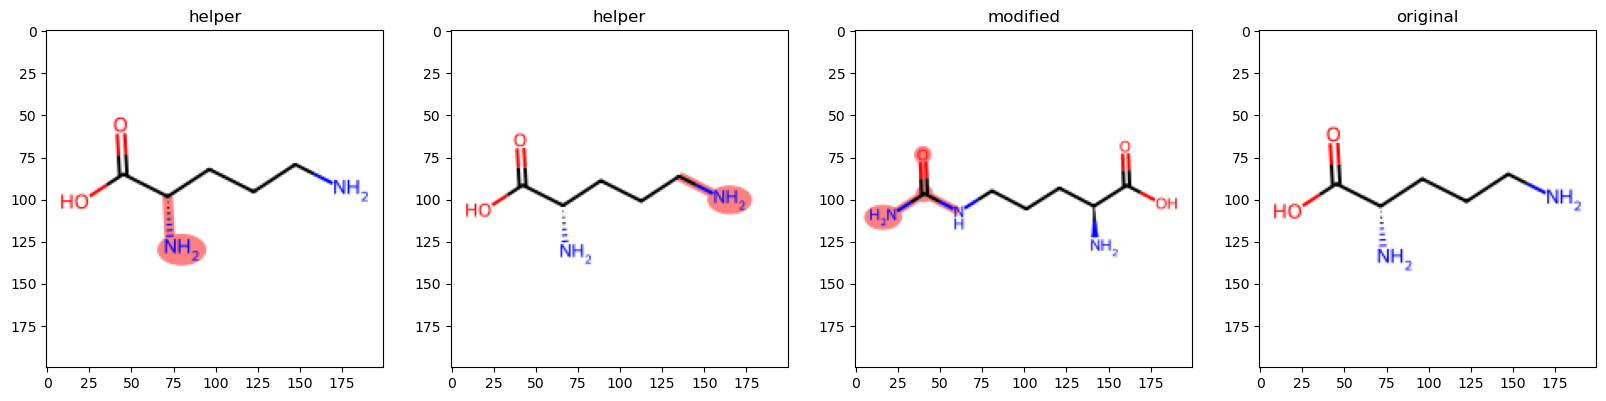

In [10]:
args = {
    'adduct': 'M+H',
    'filter_peaks_method': 'top_k',
    'filter_peaks_variable': 50,
    'mz_tolerance': 0.05,
    'ppm': 1.01,
}
jump = 1
for match in matches[1]:
    if "+H" not in data_dict_filtered[match[0]]["Adduct"]  or "+H" not in data_dict_filtered[match[1]]["Adduct"]:
        continue
    molMatch, molId = match
    if molId not in helpers:
        continue
    modifiedStructure = cachedStructures_filtered[molMatch]
    molStructure = cachedStructures_filtered[molId]
    molData = data_dict_filtered[molId]
    modifiedData = data_dict_filtered[molMatch]
    site = modSite.SiteLocator(molData, modifiedData, molStructure, args)
    if len(site.shifted) <= 2:
        continue
    
    if jump == 0:
        break
    jump -= 1

fig, ax = plt.subplots(1, len(helpers[molId]) + 2, figsize=(20, 10))
ax[-1].imshow(Chem.Draw.MolToImage(molStructure, size=(200, 200)))
ax[-1].set_title("original")
for i, helper in enumerate(helpers[molId]):
    helperStructure = cachedStructures_filtered[helper]
    notIn = [x for x in range(molStructure.GetNumAtoms()) if x not in molStructure.GetSubstructMatch(helperStructure)]
    bonds = []
    for bond in molStructure.GetBonds():
        if bond.GetBeginAtomIdx() in notIn or bond.GetEndAtomIdx() in notIn:
            bonds.append(bond.GetIdx())
    ax[i].imshow(Chem.Draw.MolToImage(molStructure, size=(200, 200), highlightAtoms=notIn, highlightBonds=bonds))
    ax[i].set_title("helper")
    print(helper, i)
notIn = [x for x in range(modifiedStructure.GetNumAtoms()) if x not in modifiedStructure.GetSubstructMatch(molStructure)]
bonds = []
for bond in modifiedStructure.GetBonds():
    if bond.GetBeginAtomIdx() in notIn or bond.GetEndAtomIdx() in notIn:
        bonds.append(bond.GetIdx())
ax[len(helpers[molId])].imshow(Chem.Draw.MolToImage(modifiedStructure, size=(200, 200), highlightAtoms=notIn, highlightBonds=bonds))
ax[len(helpers[molId])].set_title("modified")

CCMSLIB00005464399 0
CCMSLIB00005464402 1
CCMSLIB00005464389


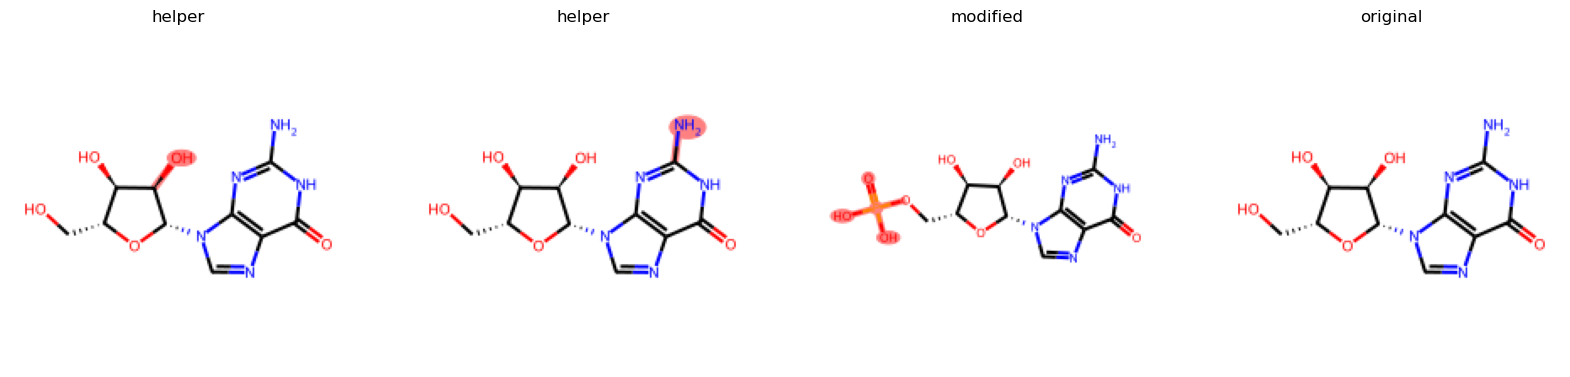

In [3]:
# index = 25
# while True:
#     try:
#         iterator = iter(helpers.keys())
#         i = 0
#         while i < index:
#             i += 1
#             molId = next(iterator)
#         molMatch = None
#         for match in matches[1]:
#             if match[1] == molId:
#                 molMatch = match[0]
#                 break
#         modifiedStructure = cachedStructures_filtered[molMatch]
#         molStructure = cachedStructures_filtered[molId]
#         molData = data_dict_filtered[molId]
#         modifiedData = data_dict_filtered[molMatch]

#         fig, ax = plt.subplots(1, len(helpers[molId]) + 2, figsize=(20, 10))
#         ax[-1].imshow(Chem.Draw.MolToImage(molStructure, size=(200, 200)))
#         ax[-1].set_title("original")
#         for i, helper in enumerate(helpers[molId]):
#             helperStructure = cachedStructures_filtered[helper]
#             notIn = [x for x in range(molStructure.GetNumAtoms()) if x not in molStructure.GetSubstructMatch(helperStructure)]
#             bonds = []
#             for bond in molStructure.GetBonds():
#                 if bond.GetBeginAtomIdx() in notIn or bond.GetEndAtomIdx() in notIn:
#                     bonds.append(bond.GetIdx())
#             ax[i].imshow(Chem.Draw.MolToImage(molStructure, size=(200, 200), highlightAtoms=notIn, highlightBonds=bonds))
#             ax[i].set_title("helper")
#             print(helper, i)
#         notIn = [x for x in range(modifiedStructure.GetNumAtoms()) if x not in modifiedStructure.GetSubstructMatch(molStructure)]
#         bonds = []
#         for bond in modifiedStructure.GetBonds():
#             if bond.GetBeginAtomIdx() in notIn or bond.GetEndAtomIdx() in notIn:
#                 bonds.append(bond.GetIdx())
#         ax[len(helpers[molId])].imshow(Chem.Draw.MolToImage(modifiedStructure, size=(200, 200), highlightAtoms=notIn, highlightBonds=bonds))
#         ax[len(helpers[molId])].set_title("modified")
#         break
#     except:
#         index += 1
#         print(index)
#         continue

# for axi in ax:
#     axi.set_xticks([])
#     axi.set_yticks([])
#     # remove border
#     for spine in axi.spines.values():
#         spine.set_visible(False)

# print(molId)

In [5]:
#usi:
usi = "mzspec:GNPS:" + library + ":" + molId
usi

'mzspec:GNPS:GNPS-MSMLS:CCMSLIB00005463552'

alignment and shifted peaks

In [4]:
args = {
    'adduct': 'M+H',
    'filter_peaks_method': 'top_k',
    'filter_peaks_variable': 50,
    'mz_tolerance': 0.05,
    'ppm': 1.01,
}
site = modSite.SiteLocator(molData, modifiedData, molStructure, args)

In [5]:
peak_images = {}
for peak in site.shifted:
    peak_weight = site.molData.get("peaks")[peak[0]][0]
    allPossibilities = site.fragments.find_fragments(peak_weight, 0.1, site.args['ppm'], site.args['mz_tolerance'])
    calculatedPossibilities, indices = site.get_structures_per_peak(peak_weight)
    if len(allPossibilities) != len(calculatedPossibilities):
        print("Error: ", peak_weight, len(allPossibilities), len(calculatedPossibilities))
        print(allPossibilities)
        print(calculatedPossibilities)
    
    for possibility in calculatedPossibilities:
        if peak_weight not in peak_images:
            peak_images[peak_weight] = []
        peak_images[peak_weight].append(possibility)



Error:  284.099121 2 1
[[1048575, 0, 0, 283.0916685538, 0], [1048575, 0, 0, 283.0916685538, 1]]
['Nc1nc2c(ncn2[C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)[nH]1']


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import SVG
import ipywidgets as widgets

In [7]:
def plot_peaks(peak):
    if len(peak) == 0:
        return
    else:
        peak = peak[0]
    n_plots = len(peak_images[peak])
    n_rows = int(np.sqrt(n_plots))
    n_cols = int(np.ceil(n_plots / n_rows))
    print(peak)
    print(n_rows, n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7, 7))
    for i, substruct in enumerate(peak_images[peak]):
        row = i // n_cols
        col = i % n_cols
        substructStructure = Chem.MolFromSmiles(substruct, sanitize=False)
        
        atomIn = [x for x in range(molStructure.GetNumAtoms()) if x in molStructure.GetSubstructMatch(substructStructure)]
        bondIn = []
        bondOut = []
        for bond in molStructure.GetBonds():
            if bond.GetBeginAtomIdx() in atomIn and bond.GetEndAtomIdx() in atomIn:
                bondIn.append(bond.GetIdx())
            else:
                bondOut.append(bond.GetIdx())
        if n_plots > 1:
            axes.flatten()[i].imshow(Chem.Draw.MolToImage(molStructure, size=(600, 600), highlightAtoms=atomIn, highlightBonds=bondIn))
        else:
            axes.imshow(Chem.Draw.MolToImage(molStructure, size=(300, 300), highlightAtoms=atomIn, highlightBonds=bondIn))
    # remove space between subplots
    fig.subplots_adjust(wspace=0, hspace=0)

    fig.tight_layout()
    plt.show()

In [8]:
options=list(peak_images.keys())
options.sort()
widgets.interact(plot_peaks, peak=widgets.SelectMultiple(options=options))

interactive(children=(SelectMultiple(description='peak', options=(284.099121,), value=()), Output()), _dom_cla…

<function __main__.plot_peaks(peak)>